__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
from shapely.geometry import Polygon

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_land.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

4426


,title,adr,latitude,longitude,priceM,ts
3980,"Участок 5,5 сот. (ИЖС)","Севастополь, ТСН СТ Дружба, 40",44.59,33.59,3.50,2022-09-15 10:31:26.039
4189,"Участок 7,1 сот. (ИЖС)","Севастополь, садовое товарищество Маяк-1",44.56,33.45,4.50,2022-09-15 10:31:26.039
1362,Участок 6 сот. (ИЖС),"Севастополь, ул. Генерала Рихтера, 29",44.57,33.56,3.20,2022-09-12 13:51:16.745


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4426 entries, 0 to 4425
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   avito_id            4426 non-null   int64         
 1   title               4426 non-null   object        
 2   price               4426 non-null   int64         
 3   obj_name            4426 non-null   object        
 4   adr                 4426 non-null   object        
 5   description         4426 non-null   object        
 6   avito_page          4426 non-null   int64         
 7   ts                  4426 non-null   datetime64[ns]
 8   place               4426 non-null   object        
 9   area                4426 non-null   float64       
 10  is_IJS              4426 non-null   bool          
 11  priceM              4426 non-null   float64       
 12  priceMU             4426 non-null   float64       
 13  area_size_category  4426 non-null   category    

In [7]:
df.sample(3)[cols]

,title,adr,latitude,longitude,priceM,ts
910,"Участок 4,5 сот. (ИЖС)","Севастополь, ул. Василия Колодкина",44.58,33.55,2.00,2022-09-08 16:04:40.227
3363,Участок 10 сот. (ИЖС),"Севастополь, СТ Лазурь",44.51,33.52,4.40,2022-09-15 10:31:26.039
918,Участок 16 сот. (ИЖС),"Севастополь, ул. Горпищенко",44.59,33.57,12.80,2022-09-08 16:04:40.227


In [8]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

4426
4426


In [9]:
# # берём самые свежие объявления
# print(len(df))
# df = df[ (df['ts']==df['ts'].max()) ].reset_index(drop=True)
# print(len(df))

# cols = ['title','adr','latitude','longitude','priceM']
# df[cols]

### ограничиваем тип объекта 

In [10]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('is_IJS')
# df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))

4426
4426


In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
689,Участок 5 сот. (ИЖС),"Севастополь, Балаклава, Склонная ул., 31А",44.52,33.59,4.30
1728,Участок 10 сот. (ИЖС),"Севастополь, ул. Лётчика Мусатова, 36",44.58,33.53,3.50
3743,Участок 8 сот. (ИЖС),"Севастополь, ул. Второй Обороны, 108/1",44.56,33.58,4.40


In [12]:
del df

In [13]:
gdf[['title','priceM','area_size_category','geometry']].sample(100).explore('area_size_category', legend=True) 

## общая статистика изменение цены

In [14]:
ts = '2022-08-01' # ограничиваем дату

In [15]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count  mean    std  min  10%   25%   50%   75%  \
area_size_category dt                                                           
<1                 2022-09-08   2.00  8.07   9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-12   2.00  8.07   9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-13   2.00  8.07   9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-15   2.00  8.07   9.79 1.15 2.53  4.61  8.07 11.54   
1-2                2022-09-08   3.00  1.80   0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-12   3.00  1.80   0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-13   3.00  1.80   0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-15   3.00  1.77   0.06 1.70 1.72  1.75  1.80  1.80   
2-4                2022-09-08 143.00  3.46   1.87 1.15 1.59  2.05  2.85  4.38   
                   2022-09-12 144.00  3.61   2.34 1.15 1.61  2.17  2.88  4.50   
                   2022-09-13 149.00  3.57   2.29 1.15 1.60  2.10  2.99  4.50   
                   2022-09-15 152.00  3.59   2.28 1.15 1.70  2.19  2.92  4.50   
4-8                2022-09-08 518.00  4.52   3.41 1.10 1.90  2.50  3.50  5.20   
                   2022-09-12 550.00  4.55   4.02 1.10 1.90  2.50  3.50  5.20   
                   2022-09-13 553.00  4.48   3.99 1.10 1.86  2.50  3.40  5.10   
                   2022-09-15 550.00  4.43   3.86 1.10 1.85  2.45  3.45  5.07   
8-20               2022-09-08 348.00  6.40   6.57 1.10 2.00  3.00  4.60  7.41   
                   2022-09-12 343.00  6.28   6.19 1.10 2.00  3.00  4.60  7.00   
                   2022-09-13 344.00  6.37   6.24 1.10 2.00  3.00  4.60  7.03   
                   2022-09-15 349.00  6.40   6.28 1.10 2.00  3.00  4.50  7.00   
20+                2022-09-08  37.00 80.51 198.40 1.10 6.30 14.00 26.00 54.00   
                   2022-09-12  38.00 54.32 142.47 1.10 2.90 10.50 21.00 47.00   
                   2022-09-13  38.00 55.97 142.34 1.10 2.97 12.38 21.00 53.00   
                   2022-09-15  43.00 51.58 135.00 1.10 2.92  8.30 18.00 44.00   

                                90%    max  
area_size_category dt                       
<1                 2022-09-08 13.61  15.00  
                   2022-09-12 13.61  15.00  
                   2022-09-13 13.61  15.00  
                   2022-09-15 13.61  15.00  
1-2                2022-09-08  1.88   1.90  
                   2022-09-12  1.88   1.90  
                   2022-09-13  1.88   1.90  
                   2022-09-15  1.80   1.80  
2-4                2022-09-08  6.00  11.70  
                   2022-09-12  6.14  20.00  
                   2022-09-13  6.00  20.00  
                   2022-09-15  5.98  20.00  
4-8                2022-09-08  8.13  29.00  
                   2022-09-12  8.00  60.00  
                   2022-09-13  8.00  60.00  
                   2022-09-15  8.00  60.00  
8-20               2022-09-08 12.00  60.00  
                   2022-09-12 11.82  48.00  
                   2022-09-13 12.00  48.00  
                   2022-09-15 12.10  48.00  
20+                2022-09-08 94.20 890.00  
                   2022-09-12 72.20 890.00  
                   2022-09-13 75.60 890.00  
                   2022-09-15 76.60 890.00

<AxesSubplot:title={'center':'цена на 2-4 сот'}, xlabel='dt'>

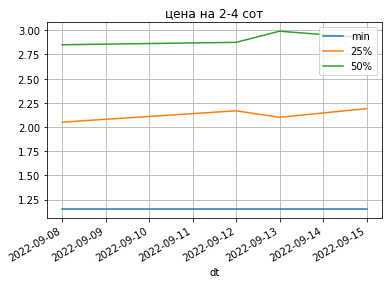

In [16]:
stat.loc['2-4',['min','25%','50%']].plot(grid=True, title='цена на 2-4 сот')

<AxesSubplot:title={'center':'цена на 8-20 сот'}, xlabel='dt'>

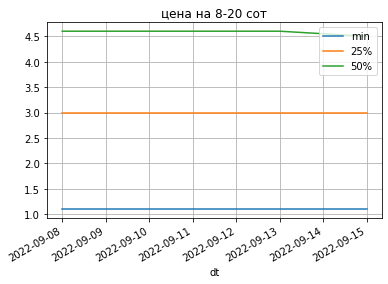

In [17]:
stat.loc['8-20',['min','25%','50%']].plot(grid=True, title='цена на 8-20 сот')

<AxesSubplot:title={'center':'цена на 4-8 сот'}, xlabel='dt'>

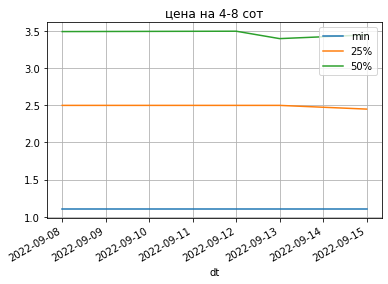

In [18]:
stat.loc['4-8',['min','25%','50%']].plot(grid=True, title='цена на 4-8 сот')

### район поиска

In [19]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([
        { 
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }
    ],crs='EPSG:4326')

frame_all.explore()

### гексагональная сетка

In [20]:
import h3
    
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame(
        { 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },
        crs=crs, 
    )

In [21]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0] )
print(len(grid))
grid.sample(2)

117


,hex_id,geometry
58,862d28577ffffff,"POLYGON ((33.98407 43.98513, 33.96270 43.95559, 33.98920 43.92657, 34.03705 43.92710, 34.05844 43.95664, 34.03196 43.98565, 33.98407 43.98513))"
49,862d288d7ffffff,"POLYGON ((33.80351 44.39251, 33.78208 44.36306, 33.80880 44.33417, 33.85692 44.33473, 33.87836 44.36417, 33.85167 44.39307, 33.80351 44.39251))"


In [22]:
ts = '2022-08-01' # ограничиваем дату
# & (gdf['priceM']<15.)
grid_values = ( 
    grid.sjoin( gdf[ (gdf['dt']>ts)  ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [23]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')
# frames_index

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames['area_id'] = range(len(frames))

frames

,area_name,geometry,area_id
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))",0
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))",1
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))",2
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))",3
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))",4
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))",5


In [24]:
# frames.plot('area_name', legend=True, cmap='GnBu', alpha=.5, edgecolor='k',figsize=(10,10),)  
frames.explore('area_name')

In [25]:
# фильтруем по области
print(len(gdf))
gdf_in_frame = gdf.sjoin( frames.query('area_id in (5,)'), how='inner', predicate='within') 
print(len(gdf_in_frame))

4426
156


In [26]:
cols = ['title','priceM','adr','area_size_category','geometry']
gdf_in_frame[cols].explore('area_size_category')#,legend=False)

In [27]:
# ctx.add_basemap(
#     gdf_in_frame[ (gdf_in_frame['dt']==gdf_in_frame['dt'].max()) ]
#       .plot(figsize=(21,21), color='r',marker='*'), 
#     crs=gdf.crs, 
#     zoom=16,
#     # source=ctx.providers.Stamen.TonerLite,
#     source=ctx.providers.OpenStreetMap.Mapnik,
# )

### изменение цены

In [28]:
stat = (
    gdf_in_frame.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count   mean  std    min    10%    25%    50%  \
area_size_category dt                                                          
2-4                2022-09-08   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-12   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-13   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-15   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
4-8                2022-09-08  22.00   3.75 2.17   1.60   2.00   2.23   2.75   
                   2022-09-12  25.00   3.48 1.89   1.45   1.80   2.20   2.80   
                   2022-09-13  24.00   3.27 1.61   1.45   1.80   2.20   2.75   
                   2022-09-15  25.00   3.21 1.61   1.45   1.80   2.20   2.70   
8-20               2022-09-08  10.00   5.81 4.85   1.65   2.42   3.12   4.10   
                   2022-09-12   9.00   5.96 4.47   1.65   2.81   3.20   4.25   
                   2022-09-13  10.00   6.18 4.27   1.65   2.96   3.39   4.53   
                   2022-09-15  11.00   5.31 4.25   1.65   2.15   2.85   3.95   
20+                2022-09-08   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-12   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-13   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-15   1.00 120.00  NaN 120.00 120.00 120.00 120.00   

                                 75%    90%    max  
area_size_category dt                               
2-4                2022-09-08   2.95   3.40   3.70  
                   2022-09-12   2.95   3.40   3.70  
                   2022-09-13   2.95   3.40   3.70  
                   2022-09-15   2.95   3.40   3.70  
4-8                2022-09-08   4.78   7.86   8.50  
                   2022-09-12   4.50   5.88   8.50  
                   2022-09-13   3.97   4.80   8.00  
                   2022-09-15   3.80   4.80   8.00  
8-20               2022-09-08   5.55  12.41  17.00  
                   2022-09-12   5.80  12.52  15.00  
                   2022-09-13   7.60  12.21  15.00  
                   2022-09-15   5.30  11.90  15.00  
20+                2022-09-08 120.00 120.00 120.00  
                   2022-09-12 120.00 120.00 120.00  
                   2022-09-13 120.00 120.00 120.00  
                   2022-09-15 120.00 120.00 120.00

<AxesSubplot:title={'center':'цена на 2-4 сот'}, xlabel='dt'>

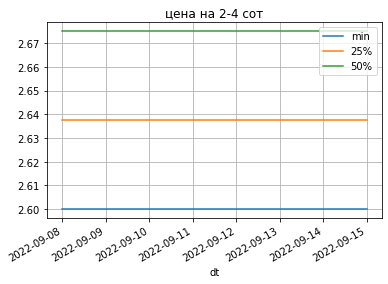

In [29]:
stat.loc['2-4',['min','25%','50%']].plot(grid=True, title='цена на 2-4 сот')

<AxesSubplot:title={'center':'цена на 4-8 сот'}, xlabel='dt'>

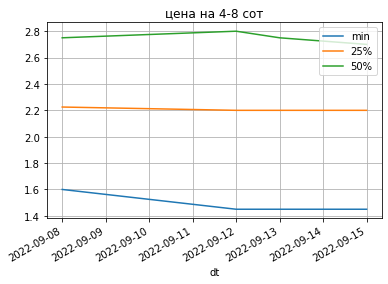

In [30]:
stat.loc['4-8',['min','25%','50%']].plot(grid=True, title='цена на 4-8 сот')

<AxesSubplot:title={'center':'цена на 8-20 сот'}, xlabel='dt'>

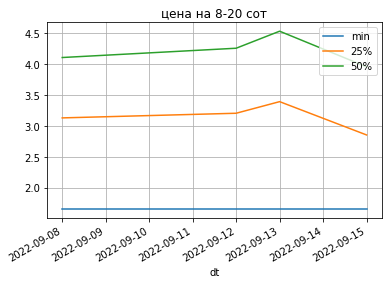

In [31]:
stat.loc['8-20',['min','25%','50%']].plot(grid=True, title='цена на 8-20 сот')

### гексагональная сетка

In [32]:
# import h3
    
# def cover_grid_hexagonal(gmtr,cell_size=9,crs='EPSG:4326'):
#     polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
#     hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
#     return gpd.GeoDataFrame(
#         { 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },
#         crs=crs, 
#     )

In [33]:
# frames[frames['area_name']=='Севастополь, кр.горка']

In [34]:
fg = frames[frames['area_name']=='Севастополь, кр.горка'].geometry.values[0]
grid = cover_grid_hexagonal( fg,cell_size=9 )
print(len(grid))
grid.sample()

32


,hex_id,geometry
2,892d28943d7ffff,"POLYGON ((33.53688 44.58919, 33.53656 44.58740, 33.53864 44.58624, 33.54105 44.58687, 33.54138 44.58866, 33.53929 44.58982, 33.53688 44.58919))"


### медиана актуальной цены

In [35]:
grid_values = (
    grid.sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

In [36]:
# import folium
# start_pos = (44.578330, 33.516509)
# # Create a map
# my_map = folium.Map(location=start_pos, zoom_start=14,)

# # Add the data
# folium.Choropleth(
#     name='choropleth',
#     geo_data=grid,
#     data=grid_values,
#     columns=['hex_id','priceM',],
#     key_on='feature.properties.hex_id',
#     fill_color='YlOrRd',
#     fill_opacity=.7,
#     line_opacity=.2,
#     legend_name='priceM median'
# ).add_to(my_map)
# my_map

In [37]:
### количество предложений

In [38]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {  return false; }

In [39]:
# # количество предложений
# from folium import Map
# from folium.plugins import HeatMap

# start_pos = (44.578330, 33.516509)

# Map(
#     location=start_pos,
#     zoom_start=12,
#     # width=500,
#     #height=2000,
# ).add_child( 
#     HeatMap( 
#         gdf[ gdf['dt']>ts ]
#         .sjoin(frames.query('area_id in (5,)'),how='inner',predicate='within')
#         [['latitude','longitude',]],
#         #radius=10.,
#         #min_opacity=3. 
#     )
# )


In [40]:
# df = pd.read_pickle(data_file)
# df['priceMU'] = df['priceM']/df['area']

# area_bins = [ 0., 1., 2., 4., 8., 20., 1e6, ]
# labels =    [ '<1', '1-2','2-4', '4-8', '8-20', '20+' ]
# df['area_size_category'] = pd.cut( df['area'], bins = area_bins, labels=labels)

# df= df.drop(columns=['area_cut'])

# df.to_pickle(data_file)
# df[['title','adr','area','area_size_category','price','priceM','priceMU']]